# 05: Training the ML algorithm

In [1]:
import SMEFT19
import pandas as pd
import shap
import numpy as np

In [2]:
d = SMEFT19.ellipse.load('../data/ellipses/rotBII.yaml')

In [3]:
ML = SMEFT19.ml.train(['../data/samples/randompoints.dat', '../data/samples/samplealbl.dat', '../data/samples/sampleaqbq.dat'],
                 '../data/samples/validationpoints.dat', '../data/MLmodels/xgb_lh.json', d['bf'], headers=0)

[0]	validation_0-rmse:16.98649
[1]	validation_0-rmse:16.14512
[2]	validation_0-rmse:15.34632
[3]	validation_0-rmse:14.58630
[4]	validation_0-rmse:13.86495
[5]	validation_0-rmse:13.18359
[6]	validation_0-rmse:12.53318
[7]	validation_0-rmse:11.91543
[8]	validation_0-rmse:11.33209
[9]	validation_0-rmse:10.77519
[10]	validation_0-rmse:10.24900
[11]	validation_0-rmse:9.74801
[12]	validation_0-rmse:9.27141
[13]	validation_0-rmse:8.82152
[14]	validation_0-rmse:8.39332
[15]	validation_0-rmse:7.98826
[16]	validation_0-rmse:7.60256
[17]	validation_0-rmse:7.23791
[18]	validation_0-rmse:6.89156
[19]	validation_0-rmse:6.56353
[20]	validation_0-rmse:6.25165
[21]	validation_0-rmse:5.95653
[22]	validation_0-rmse:5.67544
[23]	validation_0-rmse:5.40947
[24]	validation_0-rmse:5.15703
[25]	validation_0-rmse:4.91576
[26]	validation_0-rmse:4.68918
[27]	validation_0-rmse:4.47526
[28]	validation_0-rmse:4.27170
[29]	validation_0-rmse:4.07833
[30]	validation_0-rmse:3.89710
[31]	validation_0-rmse:3.72504
[32]	va

## Linear regression

Here we check that the ML approximation correctly reproduces the likelihood of the datapoints

In [4]:
ML = SMEFT19.ml.load_model('../data/MLmodels/xgb_lh.json', '../data/samples/validationpoints.dat', d['bf'])
ML.featurenames = ['C', 'al', 'bl', 'aq', 'bq']

PearsonRResult(statistic=0.9776101389536795, pvalue=0.0)

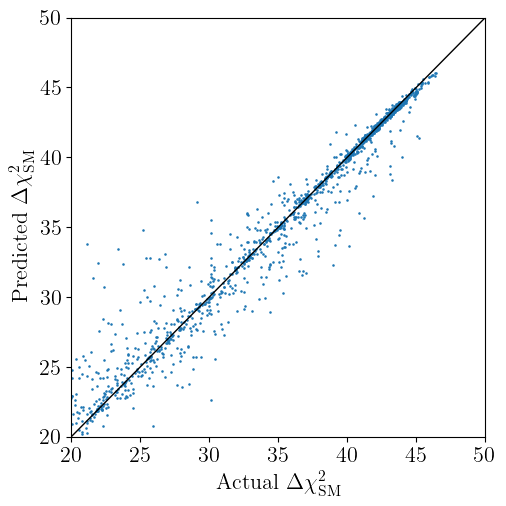

In [5]:
SMEFT19.ml.regr(ML, '../data/samples/validationpoints.dat', '../data/plots/regression_xgb')

## Distribution

Now we generate a small sample of points with a Montecarlo algorithm using the ML-approximation of the likelihood

In [6]:
newpoints = ML.newpoints(500)
df = pd.DataFrame(newpoints, columns=['C', 'al', 'bl', 'aq', 'bq'])
preds = ML.model.predict(df)

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

And compare the resulting histogram with the p.d.f of a $\chi^2$ distribution with 5 degrees of freedom

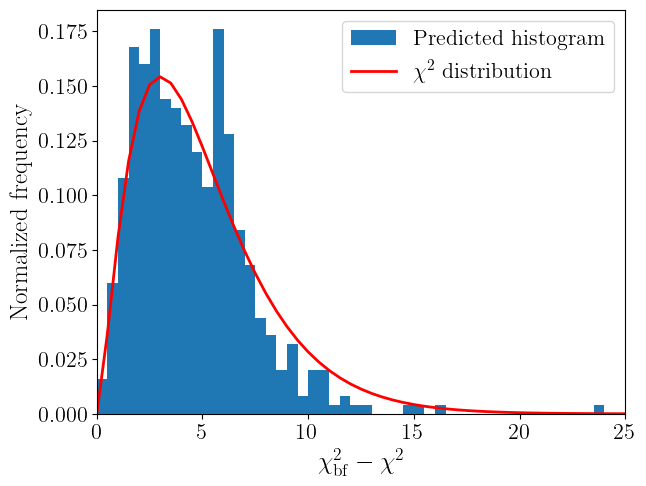

In [9]:
_ = plt.hist(2*max(preds) - 2*preds, bins=50, range=(0,25), density=True, label='Predicted histogram')
plt.plot(np.linspace(0,25,51), chi2(5).pdf(np.linspace(0,25,51)), label=r'$\chi^2$ distribution', lw=2, c='r')
plt.xlim([0,25])
plt.xlabel(r'$\chi^2_\mathrm{bf} - \chi^2$', fontsize=18)
plt.ylabel('Normalized frequency', fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/hist_xgb.pdf')
plt.savefig('../data/plots/hist_xgb.pgf')

## SHAP

In [10]:
newpoints += ML.newpoints(500)

In [11]:
ML = SMEFT19.ml.load_model('../data/MLmodels/xgb_lh.json', '../data/samples/validationpoints.dat', d['bf'])
ML.featurenames = ['C', 'al', 'bl', 'aq', 'bq']

In [12]:
dfnewpoints = pd.DataFrame(newpoints, columns=['C', 'al', 'bl', 'aq', 'bq'])
dfnewpoints['logL'] = ML.model.predict(dfnewpoints)
dfnewpoints.to_csv('../data/samples/mlpoints.dat', sep='\t', index=False)

In [13]:
explainer = shap.TreeExplainer(ML.model)
print(f'Base value: {float(explainer.expected_value)}')
bfs = pd.DataFrame(data=d['bf'].reshape(1, 5), columns = ['$C$', '$\\alpha^\\ell$',
                                              '$\\beta^\\ell$', '$\\alpha^q$',
                                              '$\\beta^q$'] )
print(f'SHAP values: {explainer.shap_values(bfs)}')
total = float(explainer.expected_value)+np.sum(explainer.shap_values(bfs))
print(f'Total prediction: {total}')

Base value: 0.5
SHAP values: [[0.8984124 1.0841255 0.1545804 1.0430342 0.5202897]]
Total prediction: 21.911547422409058


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

def SHAP_summary2(fmodel, points, fout, header=None):
    r'''
Creates a summary plot of the average SHAP values on a dataset.

:Arguments:

    - fmodel\: Path to the file where the model was saved.
    - points\: Pandas Dataframe containing the dataset.
    - fout\: Path to save the plot (pdf only).
    - header\: If the data file contains headers in the first row, 0.
    '''

    model = XGBRegressor()
    model.load_model(fmodel)
    explainer = shap.TreeExplainer(model)
    df = pd.read_csv(points, sep='\t', names=['$C$', '$\\alpha^\\ell$',
                                              '$\\beta^\\ell$', '$\\alpha^q$',
                                              '$\\beta^q$', 'logL'], header=header)
    features = ['$C$', '$\\alpha^\\ell$', '$\\beta^\\ell$', '$\\alpha^q$', '$\\beta^q$']
    X = df[features]
    sv = explainer(X)
    #shap.plots.beeswarm(sv, color_bar=False, show=False)
    shap.plots.beeswarm(sv, show=False)
    plt.xticks(fontsize=16)
    #plt.tight_layout(pad=0.5)
    plt.savefig(fout+'.pdf')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


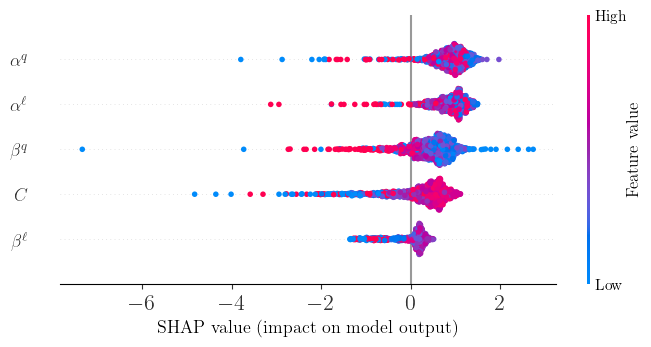

In [5]:
SHAP_summary2('../data/MLmodels/xgb_lh.json', '../data/samples/mlpoints.dat', '../data/plots/SHAP_summary', 0)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


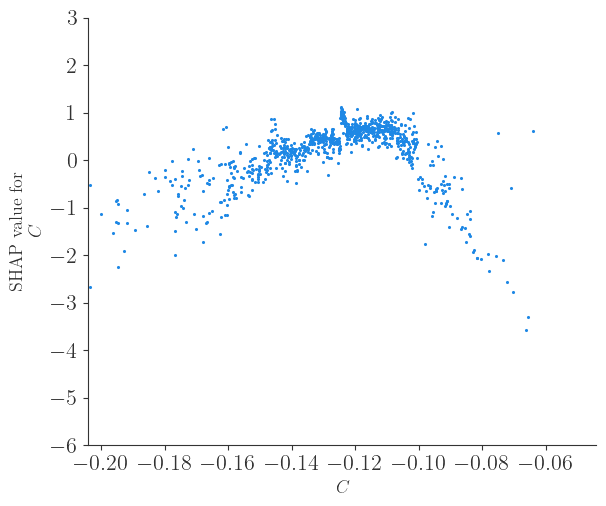

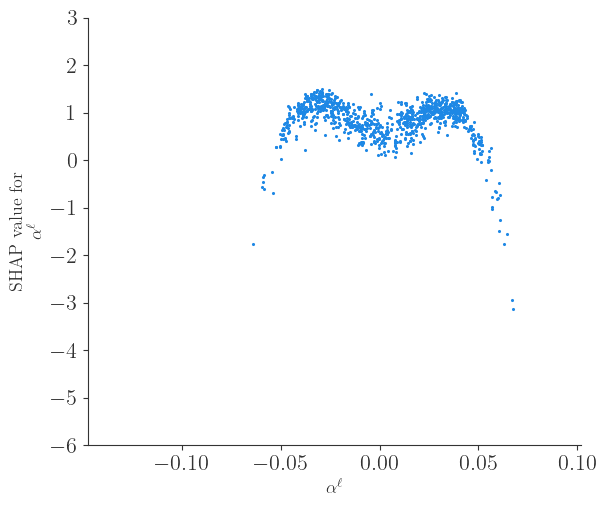

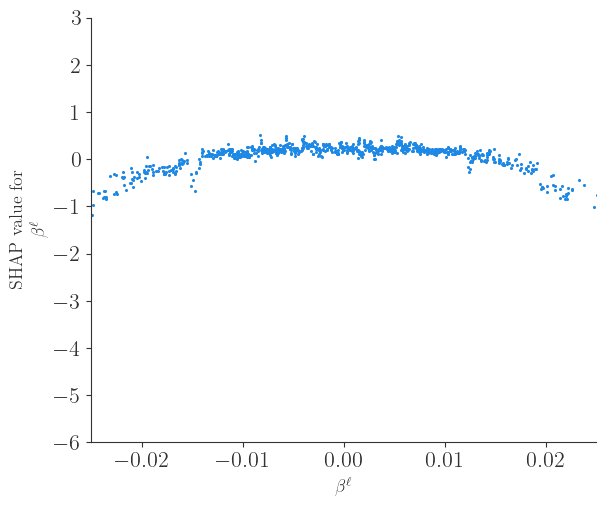

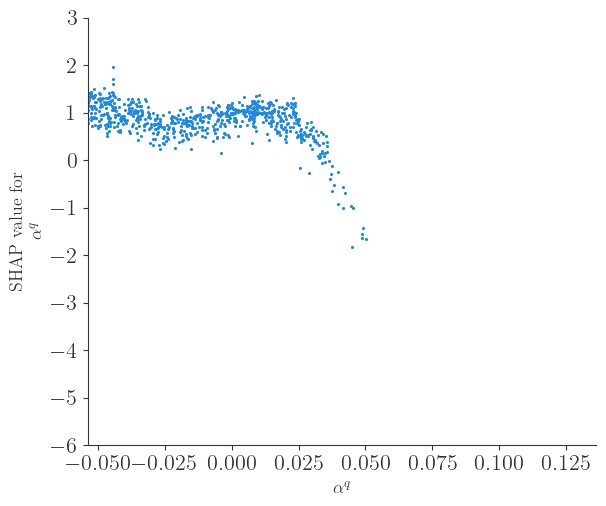

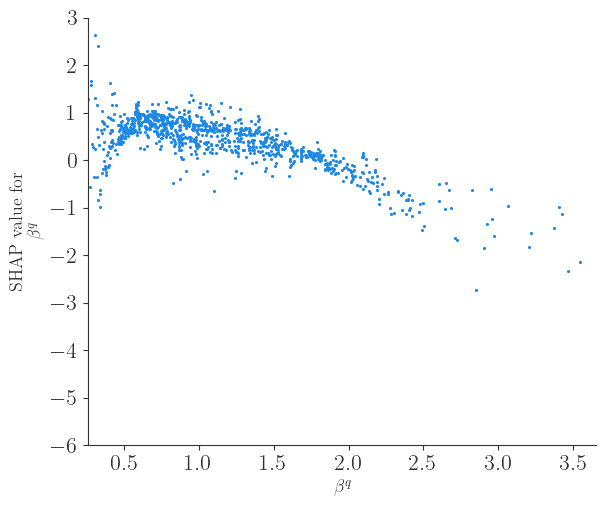

In [27]:
names = ['C', 'al', 'bl', 'aq', 'bq']
bf = d["bf"]
ranges = [[-0.08, 0.08], [-0.18, 0.07], [-0.025, 0.025], [-0.07, 0.12], [-0.6,2.8]]
for i in range(5):
    SMEFT19.ml.SHAP_param('../data/MLmodels/xgb_lh.json', '../data/samples/mlpoints.dat', i, 0)
    ax = plt.gca()
    plt.xlim([bf[i]+ranges[i][0], bf[i]+ranges[i][1]])
    #ax.set_xticks(np.linspace(ranges[i][0], ranges[i][1], 5))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout(pad=0.5)
    plt.savefig(f'../data/plots/SHAP_{names[i]}.pdf')

# Scenario III

In [2]:
d = SMEFT19.ellipse.load('../data/ellipses/rotBIII.yaml')

In [3]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=2500, early_stopping_rounds=250, n_jobs=8, learning_rate=0.15, max_depth=25)

In [31]:
ML = SMEFT19.ml.train(['../data/samples/training_III.dat'],
                 '../data/samples/validationpoints_III.dat', '../data/MLmodels/xgb_lh_rotBIII.json', d['bf'], SMEFT19.scenarios.rotBIII(), headers=0, model=model)

[0]	validation_0-rmse:14.72187
[1]	validation_0-rmse:12.58665
[2]	validation_0-rmse:10.77188
[3]	validation_0-rmse:9.24145
[4]	validation_0-rmse:7.94557
[5]	validation_0-rmse:6.83904
[6]	validation_0-rmse:5.90647
[7]	validation_0-rmse:5.11231
[8]	validation_0-rmse:4.44618
[9]	validation_0-rmse:3.88086
[10]	validation_0-rmse:3.41022
[11]	validation_0-rmse:3.01718
[12]	validation_0-rmse:2.69311
[13]	validation_0-rmse:2.41649
[14]	validation_0-rmse:2.19072
[15]	validation_0-rmse:2.00348
[16]	validation_0-rmse:1.85686
[17]	validation_0-rmse:1.73177
[18]	validation_0-rmse:1.63118
[19]	validation_0-rmse:1.55035
[20]	validation_0-rmse:1.48683
[21]	validation_0-rmse:1.43013
[22]	validation_0-rmse:1.38415
[23]	validation_0-rmse:1.34244
[24]	validation_0-rmse:1.30892
[25]	validation_0-rmse:1.28029
[26]	validation_0-rmse:1.25960
[27]	validation_0-rmse:1.24356
[28]	validation_0-rmse:1.22871
[29]	validation_0-rmse:1.21799
[30]	validation_0-rmse:1.20784
[31]	validation_0-rmse:1.19980
[32]	validation

In [3]:
ML = SMEFT19.ml.load_model('../data/MLmodels/xgb_lh_rotBIII.json', '../data/samples/validationpoints_III.dat', d['bf'], SMEFT19.scenarios.rotBIII())

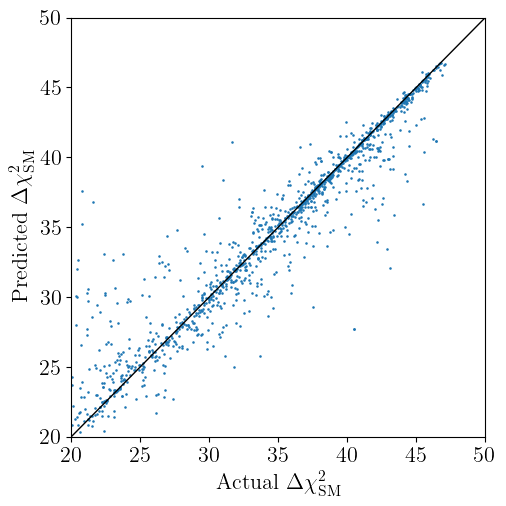

In [32]:
regres = SMEFT19.ml.regr(ML, '../data/samples/validationpoints_III.dat', '../data/plots/regression_xgb_III')

In [33]:
regres

PearsonRResult(statistic=0.9448405016513274, pvalue=0.0)

In [98]:
newpoints = []
preds = []
x0 = d['bf']
while len(preds) < 5000:
    p = np.random.multivariate_normal([0, 0, 0], np.diag([0.3**2, 0.3**2, 3**2])*1e-3)
    if p[0]+x0[0] < -0.3 or p[0]+x0[0] > 0 or p[1]+x0[1] < -0.3 or p[1]+x0[1] > 0 or p[2] + x0[2] < 0 or p[2] + x0[2] > 3:
        x0 = np.random.uniform([-0.3, -0.3, 0], [0, 0, 3])
        p = np.zeros(3)
    u = np.random.uniform()
    pred_p = float(ML.model.predict(pd.DataFrame([p+x0], columns=ML.likelihood.scenario.pars)))
    if pred_p > np.log(u) - d['L']:
        x0 = x0 + p
        newpoints.append(x0)
        preds.append(pred_p)

### Sampling with the ML

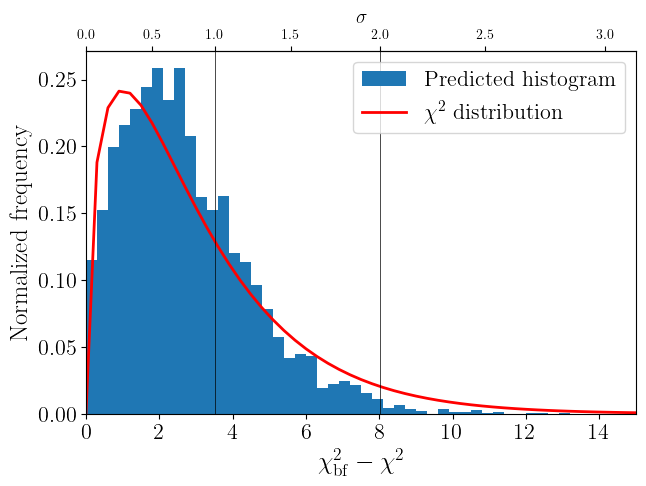

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np
from flavio.statistics.functions import delta_chi2, pull

_ = plt.hist(list(-2*d['L'] - 2*np.array(preds)), bins=50, range=(0,15), density=True, label='Predicted histogram')
plt.plot(np.linspace(0,15,51), chi2(3).pdf(np.linspace(0,15,51)), label=r'$\chi^2$ distribution', lw=2, c='r')
plt.xlim([0,15])
plt.xlabel(r'$\chi^2_\mathrm{bf} - \chi^2$', fontsize=18)
plt.ylabel('Normalized frequency', fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(delta_chi2(1, 3), lw=0.5, c='k')
plt.axvline(delta_chi2(2, 3), lw=0.5, c='k')
ax = plt.gca()
chi2sigma = np.vectorize(lambda x: pull(x, 3), otypes=[float])
#chi2sigma = lambda x: print(x)
sigma2chi = np.vectorize(lambda x: delta_chi2(x, 3), otypes=[float])
#sigma2chi = lambda x: print(str(type(x)) + '\t' + str(x))
#sigma2chi = lambda x: print([delta_chi2(x0, 3) for x0 in x])
ax_sigma = ax.secondary_xaxis('top', functions=(chi2sigma, sigma2chi))
ax_sigma.set_xlabel(r"$\sigma$")
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/hist_xgb_III.pdf')
plt.savefig('../data/plots/hist_xgb_III.pgf')

Text(0, 0.5, '$C_3$')

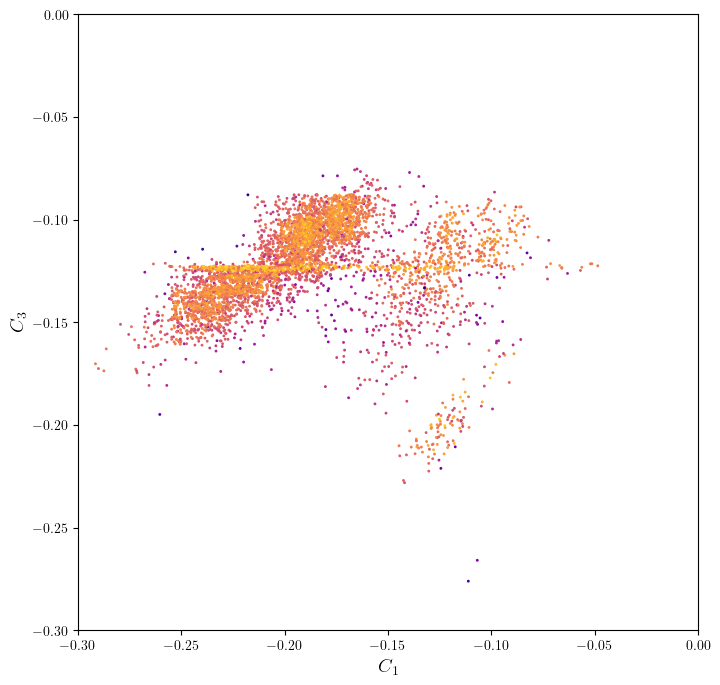

In [51]:
fig = plt.figure(figsize=(8,8))
plt.scatter([p[0] for p in newpoints], [p[1] for p in newpoints], s=1.1, c=preds, cmap='plasma')
plt.xlim([-0.3, 0])
plt.ylim([-0.3, 0])
plt.xlabel(r'$C_1$')
plt.ylabel(r'$C_3$')

Text(0, 0.5, '$\\beta^q$')

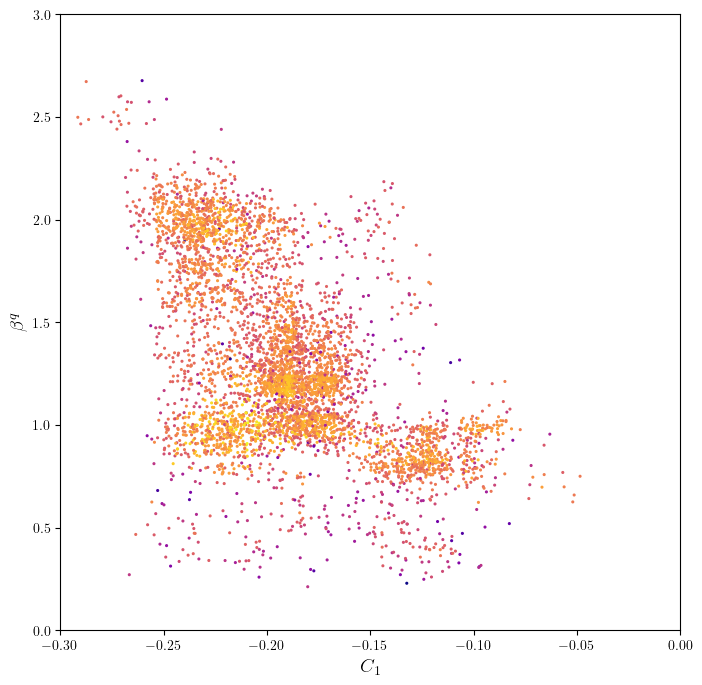

In [52]:
fig = plt.figure(figsize=(8,8))
plt.scatter([p[0] for p in newpoints], [p[2] for p in newpoints], s=1.5, c=preds, cmap='plasma')
plt.xlim([-0.3, 0])
plt.ylim([0, 3])
plt.xlabel(r'$C_1$')
plt.ylabel(r'$\beta^q$')

Text(0, 0.5, '$\\beta^q$')

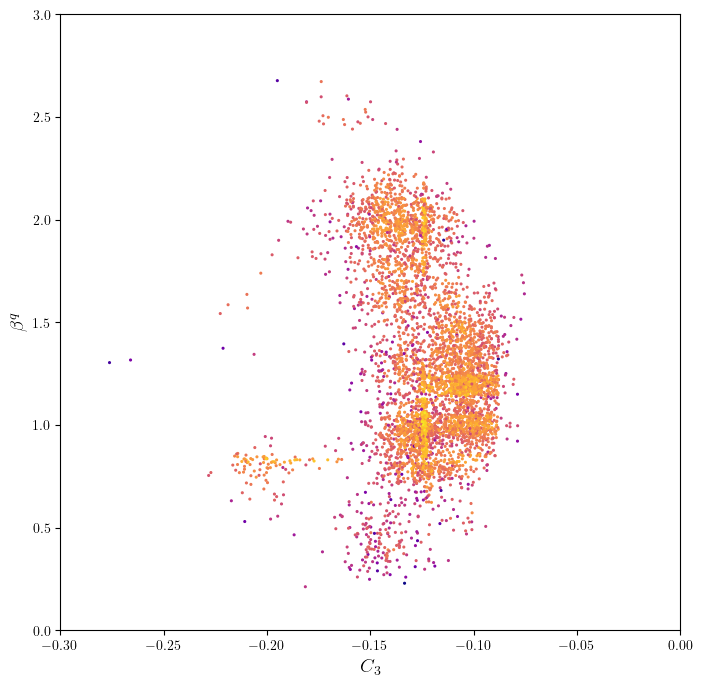

In [53]:
fig = plt.figure(figsize=(8,8))
plt.scatter([p[1] for p in newpoints], [p[2] for p in newpoints], s=1.5, c=preds, cmap='plasma')
plt.ylim([0, 3])
plt.xlim([-0.3, 0])
plt.xlabel(r'$C_3$')
plt.ylabel(r'$\beta^q$')

In [71]:
df_ML = pd.DataFrame({'C1': [p[0] for p in newpoints], 'C3': [p[1] for p in newpoints], 'bq': [p[2] for p in newpoints], 'pred': preds})
df_ML.to_csv('../data/samples/mlpoints_scIII.csv')

In [37]:
df_ML = pd.read_csv('../data/samples/mlpoints_scIII.csv')
preds = df_ML['pred']
newpoints = [[v[1], v[2], v[3]] for v in df_ML.values]

In [39]:
import matplotlib.pyplot as plt
import matplotlib
import scipy
import flavio
from flavio.statistics.functions import delta_chi2

def listpoint(x):
    r'''
If passed a single 2-tuple (representing one point), it returns a list containing the tuple.
If passed more than 1 2-tuple (representing several points), returns the argument.
TODO: Rewrite in python 3.10 using match&case syntax.
    '''
    if len(x) == 2:
        if len(np.array(x).flat) == 2:
            return [x,]
        else:
            return x
    else:
        return x

def likelihood_plot2(grid, xmin, xmax, ymin, ymax, axlabels, fout=None, locleg=0, n_sigma=(1, 2),
                    colors=None, styles=None, widths=None, ticks=0.5, bf=None):
    r'''
Plots a contour plot of the log-likelihood of the fit.

:Arguments:

    - grid\: List containing the x coordinates, y corrdinates
      and a dictionary for the likelihood values in the grid.
    - xmin\: Minimum value of the `x` coordinate.
    - xmax\: Maximum value of the `x` coordinate.
    - ymin\: Minimum value of the `y` coordinate.
    - ymax\: Maximum value of the `y` coordinate.
    - axlabels\: List containing two strings to label the `x` and `y` axes.
    - [fout\: Path to the files where the plots will be saved.
      Two files are created, one `.pdf` and one `.pgf` (to use in TeX).
      Extensions are added automatically.]
    - [locleg\: Position of the legend of the plot, using `matplotlib`'s syntaxis.
      Default=0 (best position).]
    - [n_sigma\: List containing the significance (in sigmas) of each contour. Default = (1,2).]
    - [colors\: List with the colors of each contour. Default: flavio palette.]
    - [styles\: List with the linestyles of each contour. Default: All solid.]
    - [widths\: List with the linewidths of each contour. Default: All 1pt.]
    - [ticks\: Interval between ticks in both axes. Default:0.5]
    - [bf\: Coordinates of the best fit point(s). It can be `None` (no point marked)
      or a list containing two floats (one point marked). Default: `None`.]
    '''

    fig = plt.figure(figsize=(7, 6))
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    nfits = len(grid[2])
    if colors is None:
        _cols = [i%9 for i in range(nfits)]
    else:
        _cols = colors
    if styles is None:
        lstyle = ['solid',]*nfits
    else:
        lstyle = styles
    if widths is None:
        lwidths = [1,]*nfits
    else:
        lwidths = widths
    x = grid[0]
    y = grid[1]
    zl = grid[2]
    handles = []
    for i, z in enumerate(zl.values()):
        chi = -2*(z.T-np.max(z))
        # get the correct values for 2D confidence/credibility contours for n sigma
        if isinstance(n_sigma, float) or isinstance(n_sigma, int):
            levels = [delta_chi2(n_sigma, dof=2)]
        else:
            levels = [delta_chi2(n, dof=2) for n in n_sigma]
        hatch_contour(x=x, y=y, z=chi, levels=levels, col=_cols[i], label=list(zl.keys())[i],
                      interpolation_factor=5, hatched=False,
                      contour_args={'linestyles':lstyle[i], 'linewidths':lwidths[i]})
        proxy_patch = plt.Line2D([0], [0], color=flavio.plots.colors.set1[_cols[i]], label=list(zl.keys())[i])
        handles.append(proxy_patch)
        if bf is not None:
            for p in listpoint(bf):
                plt.scatter(*p, marker='x', color='black')
    plt.xlabel(axlabels[0], fontsize=18)
    plt.ylabel(axlabels[1], fontsize=18)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    ax = fig.gca()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if isinstance(ticks, float):
        xticks = ticks
        yticks = ticks
    else:
        xticks = ticks[0]
        yticks = ticks[1]
    ax.xaxis.set_ticks(np.arange(xmin, xmax+1e-5, xticks))
    ax.yaxis.set_ticks(np.arange(ymin, ymax+1e-5, yticks))
    pars = {r'$C_1$':0, r'$C_3$': 1, r'$\beta_q$':2}
    mlpoints = plt.scatter([p[pars[axlabels[0]]] for p in newpoints], [p[pars[axlabels[1]]] for p in newpoints], s=1.5, c=2*np.array(preds), cmap='plasma', label='ML points')
    cbar = fig.colorbar(mlpoints, label=r'Predicted $\Delta \chi^2_\mathrm{SM}$', aspect=40)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(handles=handles, loc=locleg, fontsize=16)
    plt.tight_layout(pad=0.5)
    if fout is not None:
        fig.savefig(fout+'.pdf')
        fig.savefig(fout+'.pgf')

def hatch_contour(x, y, z, levels, interpolation_factor=1, interpolation_order=2, col=0,
                  label=None, hatched=True, contour_args=None, contourf_args=None):
    r"""
Plots coloured and hatched confidence contours (or bands) given numerical
input arrays.Based on the `flavio` function

:Arguments:

    - x, y\: 2D arrays containg x and y values as returned by numpy.meshgrid
    - z\: value of the function to plot. 2D array in the same shape as `x` and
      `y`. The lowest value of the function should be 0 (i.e. the best fit point).
    - levels\: list of function values where to draw the contours. They should
      be positive and in ascending order.
    - [interpolation factor\:: in between the points on the grid,
      the functioncan be interpolated to get smoother contours.
      This parameter sets the number of subdivisions (default: 1, i.e. no
      interpolation). It should be larger than 1.]
    - [col\: number between 0 and 9 to choose the color of the plot
      from a predefined palette.]
    - [label\: label that will be added to a legend created with `maplotlib.pyplot.legend()`.]
    - [contour_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contour()` (that draws the contour lines).]
    - [contourf_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contourf()` (that paints the contour filling).]
    """
    contour_args = contour_args or {}
    contourf_args = contour_args or {}
    if interpolation_factor > 1:
        x = scipy.ndimage.zoom(x, zoom=interpolation_factor, order=1)
        y = scipy.ndimage.zoom(y, zoom=interpolation_factor, order=1)
        z = scipy.ndimage.zoom(z, zoom=interpolation_factor, order=interpolation_order)
    if isinstance(col, int):
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [flavio.plots.colors.set1[col]]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [flavio.plots.colors.pastel[col] +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]
    else:
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [darken_color(matplotlib.colors.to_rgb(col), 0.7)]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [matplotlib.colors.to_rgb(col) +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]

    if hatched:
        hl = []
        for i in range(0, N):
            hl.append(hatches[col]*(N-i))
        hl.append(None)
        _contourf_args['hatches'] = hl
    _contour_args['linestyles'] = 'solid'
    _contour_args.update(contour_args)
    _contourf_args.update(contourf_args)
    # for the filling, need to add zero contour
    levelsf = [np.min(z)] + list(levels)
    ax = plt.gca()
    CF = ax.contourf(x, y, z, levels=levelsf, **_contourf_args)
    CS = ax.contour(x, y, z, levels=levels, **_contour_args)
    return (CS, CF)

In [29]:
dim_min = [-0.3, -0.3, 0]
dim_max = [0, 0.0, 3.0]
coefs = ['C1', 'C3', 'bq']

In [30]:
d_ell = SMEFT19.ellipse.load('../data/ellipses/rotBIII.yaml')
bf3 = d_ell['bf']

d_ell_2 = SMEFT19.ellipse.load('../data/ellipses/rotBIII_2.yaml')
bf3_2 = d_ell_2['bf']

In [25]:
def read_meshgrid(par_x, par_y):
    index_x = coefs.index(par_x)
    index_y = coefs.index(par_y)
    xcoords = np.linspace(dim_min[index_x], dim_max[index_x], 50)
    ycoords = np.linspace(dim_min[index_y], dim_max[index_y], 50)
    d = {}
    #d[r'$R_{K^{(*)}}$'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}_RK.dat", sep = '\t', header=None).values.T
    #d[r'LFU $b\to c \ell \nu$'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}_RD.dat", sep = '\t', header=None).values.T
    #d['LFV'] = pd.read_csv(f"../data/likelihood/likelihood_rotBII_{par_x}{par_y}_LFV.dat", sep = '\t', header=None).values.T
    #d[r'$b\to q \nu \nu$'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}_bqnunu.dat", sep = '\t', header=None).values.T
    d['Global Likelihood'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}.dat", sep = '\t', header=None).values.T
    return (xcoords, ycoords, d)

linewidths is ignored by contourf


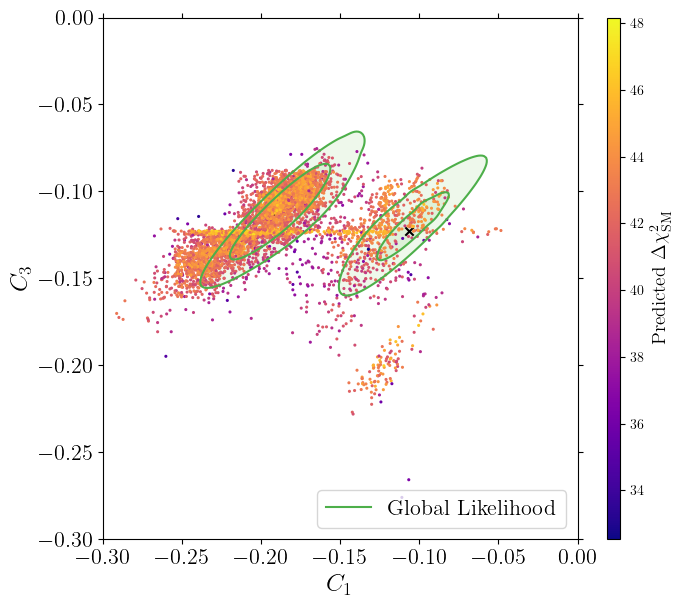

In [40]:
likelihood_plot2(read_meshgrid('C1', 'C3'),
                -0.3, 0.0, -0.3, 0.0, [r'$C_1$', r'$C_3$'], locleg='lower right',
                colors=[2], bf=([bf3[0], bf3[1]], [bf3_2[0], bf3_2[1]]),
                widths=[1.5,]*5, ticks=(0.05, 0.05),  fout='../data/plots/scIII_ML_C1C3')

linewidths is ignored by contourf


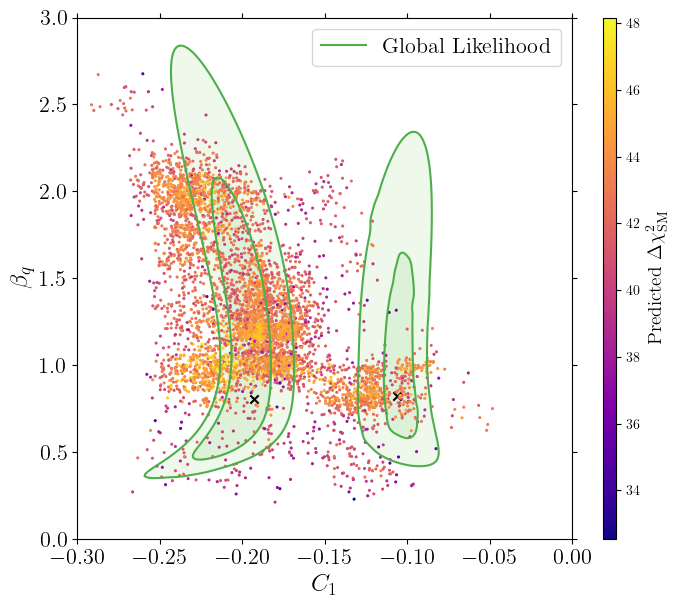

In [41]:
likelihood_plot2(read_meshgrid('C1', 'bq'),
                -0.3, 0.0, 0.0, 3.0, [r'$C_1$', r'$\beta_q$'], locleg='upper right',
                colors=[2], bf=([bf3[0], bf3[2]], [bf3_2[0], bf3_2[2]]),
                widths=[1.5,]*5, ticks=(0.05, 0.5),  fout='../data/plots/scIII_ML_C1bq')

linewidths is ignored by contourf


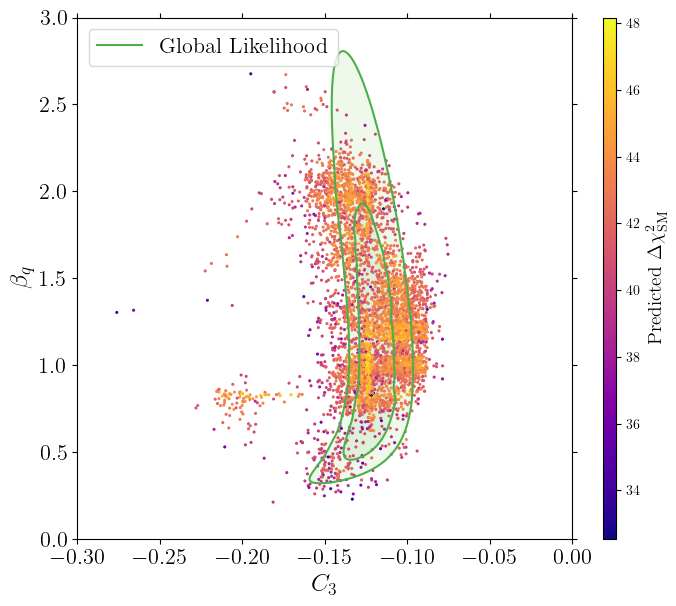

In [42]:
likelihood_plot2(read_meshgrid('C3', 'bq'),
                -0.3, 0.0, 0.0, 3.0, [r'$C_3$', r'$\beta_q$'], locleg='upper left',
                colors=[2], bf=([bf3[1], bf3[2]]),
                widths=[1.5,]*5, ticks=(0.05, 0.5),  fout='../data/plots/scIII_ML_C3bq')

### Likelihood contours with the ML

In [45]:
bf = d['bf']


dim_min = [-0.3, -0.3, 0]
dim_max = [0, 0.0, 3.0]
N = 50
coefs = ['C1', 'C3', 'bq']

In [47]:
from copy import deepcopy

for (fit_x, fit_y) in [('C1', 'C3'), ('C1', 'bq'), ('C3', 'bq')]:

    id_x = coefs.index(fit_x)
    id_y = coefs.index(fit_y)
    def lh(num: int) -> float:
        xmin = dim_min[id_x]
        xmax = dim_max[id_x]
        ymin = dim_min[id_y]
        ymax = dim_max[id_y]
        xmargin = 0.02*(xmax-xmin)
        ymargin = 0.02*(ymax-ymin)
        ix = num % N
        iy = num // N
        x = (xmin-xmargin) + ix/N * ((xmax+xmargin) - (xmin-xmargin))
        y = (ymin-ymargin) + iy/N * ((ymax+ymargin) - (ymin-ymargin))
        lh_point = deepcopy(bf)
        lh_point[id_x] = x
        lh_point[id_y] = y
        lg = float(ML.model.predict(pd.DataFrame([lh_point], columns=ML.likelihood.scenario.pars)))
        return max(lg, -100)
     
    with open( f"../data/likelihood/MLlikelihood_rotBIII_{fit_x}{fit_y}.dat", 'at') as f_global:
        for i in range(N**2):
            lg = lh(i)
            if i % N == N-1:
                sep = '\n'
                f_global.flush()
                print(f"Plot for {fit_x}-{fit_y}: {i}/{N**2} ({i/N**2*100:.2f}%)")
            else:
                sep = '\t'
            f_global.write(f'{lg}{sep}')

Plot for C1-C3: 49/2500 (1.96%)
Plot for C1-C3: 99/2500 (3.96%)
Plot for C1-C3: 149/2500 (5.96%)
Plot for C1-C3: 199/2500 (7.96%)
Plot for C1-C3: 249/2500 (9.96%)
Plot for C1-C3: 299/2500 (11.96%)
Plot for C1-C3: 349/2500 (13.96%)
Plot for C1-C3: 399/2500 (15.96%)
Plot for C1-C3: 449/2500 (17.96%)
Plot for C1-C3: 499/2500 (19.96%)
Plot for C1-C3: 549/2500 (21.96%)
Plot for C1-C3: 599/2500 (23.96%)
Plot for C1-C3: 649/2500 (25.96%)
Plot for C1-C3: 699/2500 (27.96%)
Plot for C1-C3: 749/2500 (29.96%)
Plot for C1-C3: 799/2500 (31.96%)
Plot for C1-C3: 849/2500 (33.96%)
Plot for C1-C3: 899/2500 (35.96%)
Plot for C1-C3: 949/2500 (37.96%)
Plot for C1-C3: 999/2500 (39.96%)
Plot for C1-C3: 1049/2500 (41.96%)
Plot for C1-C3: 1099/2500 (43.96%)
Plot for C1-C3: 1149/2500 (45.96%)
Plot for C1-C3: 1199/2500 (47.96%)
Plot for C1-C3: 1249/2500 (49.96%)
Plot for C1-C3: 1299/2500 (51.96%)
Plot for C1-C3: 1349/2500 (53.96%)
Plot for C1-C3: 1399/2500 (55.96%)
Plot for C1-C3: 1449/2500 (57.96%)
Plot for C1-

In [49]:
def likelihood_plot(grid, xmin, xmax, ymin, ymax, axlabels, fout=None, locleg=0, n_sigma=(1, 2),
                    colors=None, styles=None, widths=None, ticks=0.5, bf=None):
    r'''
Plots a contour plot of the log-likelihood of the fit.

:Arguments:

    - grid\: List containing the x coordinates, y corrdinates
      and a dictionary for the likelihood values in the grid.
    - xmin\: Minimum value of the `x` coordinate.
    - xmax\: Maximum value of the `x` coordinate.
    - ymin\: Minimum value of the `y` coordinate.
    - ymax\: Maximum value of the `y` coordinate.
    - axlabels\: List containing two strings to label the `x` and `y` axes.
    - [fout\: Path to the files where the plots will be saved.
      Two files are created, one `.pdf` and one `.pgf` (to use in TeX).
      Extensions are added automatically.]
    - [locleg\: Position of the legend of the plot, using `matplotlib`'s syntaxis.
      Default=0 (best position).]
    - [n_sigma\: List containing the significance (in sigmas) of each contour. Default = (1,2).]
    - [colors\: List with the colors of each contour. Default: flavio palette.]
    - [styles\: List with the linestyles of each contour. Default: All solid.]
    - [widths\: List with the linewidths of each contour. Default: All 1pt.]
    - [ticks\: Interval between ticks in both axes. Default:0.5]
    - [bf\: Coordinates of the best fit point(s). It can be `None` (no point marked)
      or a list containing two floats (one point marked). Default: `None`.]
    '''

    fig = plt.figure(figsize=(7, 6))
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    nfits = len(grid[2])
    if colors is None:
        _cols = [i%9 for i in range(nfits)]
    else:
        _cols = colors
    if styles is None:
        lstyle = ['solid',]*nfits
    else:
        lstyle = styles
    if widths is None:
        lwidths = [1,]*nfits
    else:
        lwidths = widths
    x = grid[0]
    y = grid[1]
    zl = grid[2]
    handles = []
    for i, z in enumerate(zl.values()):
        chi = -2*(z.T-np.max(z))
        # get the correct values for 2D confidence/credibility contours for n sigma
        if isinstance(n_sigma, float) or isinstance(n_sigma, int):
            levels = [delta_chi2(n_sigma, dof=2)]
        else:
            levels = [delta_chi2(n, dof=2) for n in n_sigma]
        hatch_contour(x=x, y=y, z=chi, levels=levels, col=_cols[i], label=list(zl.keys())[i],
                      interpolation_factor=5, hatched=False,
                      contour_args={'linestyles':lstyle[i], 'linewidths':lwidths[i]})
        proxy_patch = plt.Line2D([0], [0], color=flavio.plots.colors.set1[_cols[i]], label=list(zl.keys())[i])
        handles.append(proxy_patch)
        if bf is not None:
            for p in listpoint(bf):
                plt.scatter(*p, marker='x', color='black')
    plt.xlabel(axlabels[0], fontsize=18)
    plt.ylabel(axlabels[1], fontsize=18)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    ax = fig.gca()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if isinstance(ticks, float):
        xticks = ticks
        yticks = ticks
    else:
        xticks = ticks[0]
        yticks = ticks[1]
    ax.xaxis.set_ticks(np.arange(xmin, xmax+1e-5, xticks))
    ax.yaxis.set_ticks(np.arange(ymin, ymax+1e-5, yticks))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(handles=handles, loc=locleg, fontsize=16)
    plt.tight_layout(pad=0.5)
    if fout is not None:
        fig.savefig(fout+'.pdf')
        fig.savefig(fout+'.pgf')

def hatch_contour(x, y, z, levels, interpolation_factor=1, interpolation_order=2, col=0,
                  label=None, hatched=True, contour_args=None, contourf_args=None):
    r"""
Plots coloured and hatched confidence contours (or bands) given numerical
input arrays.Based on the `flavio` function

:Arguments:

    - x, y\: 2D arrays containg x and y values as returned by numpy.meshgrid
    - z\: value of the function to plot. 2D array in the same shape as `x` and
      `y`. The lowest value of the function should be 0 (i.e. the best fit point).
    - levels\: list of function values where to draw the contours. They should
      be positive and in ascending order.
    - [interpolation factor\:: in between the points on the grid,
      the functioncan be interpolated to get smoother contours.
      This parameter sets the number of subdivisions (default: 1, i.e. no
      interpolation). It should be larger than 1.]
    - [col\: number between 0 and 9 to choose the color of the plot
      from a predefined palette.]
    - [label\: label that will be added to a legend created with `maplotlib.pyplot.legend()`.]
    - [contour_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contour()` (that draws the contour lines).]
    - [contourf_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contourf()` (that paints the contour filling).]
    """
    contour_args = contour_args or {}
    contourf_args = contour_args or {}
    if interpolation_factor > 1:
        x = scipy.ndimage.zoom(x, zoom=interpolation_factor, order=1)
        y = scipy.ndimage.zoom(y, zoom=interpolation_factor, order=1)
        z = scipy.ndimage.zoom(z, zoom=interpolation_factor, order=interpolation_order)
    if isinstance(col, int):
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [flavio.plots.colors.set1[col]]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [flavio.plots.colors.pastel[col] +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]
    else:
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [darken_color(matplotlib.colors.to_rgb(col), 0.7)]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [matplotlib.colors.to_rgb(col) +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]

    if hatched:
        hl = []
        for i in range(0, N):
            hl.append(hatches[col]*(N-i))
        hl.append(None)
        _contourf_args['hatches'] = hl
    _contour_args['linestyles'] = 'solid'
    _contour_args.update(contour_args)
    _contourf_args.update(contourf_args)
    # for the filling, need to add zero contour
    levelsf = [np.min(z)] + list(levels)
    ax = plt.gca()
    CF = ax.contourf(x, y, z, levels=levelsf, **_contourf_args)
    CS = ax.contour(x, y, z, levels=levels, **_contour_args)
    return (CS, CF)

In [54]:
def read_meshgrid2(par_x, par_y):
    index_x = coefs.index(par_x)
    index_y = coefs.index(par_y)
    xcoords = np.linspace(dim_min[index_x], dim_max[index_x], 50)
    ycoords = np.linspace(dim_min[index_y], dim_max[index_y], 50)
    d = {}
    #d[r'$R_{K^{(*)}}$'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}_RK.dat", sep = '\t', header=None).values.T
    #d[r'LFU $b\to c \ell \nu$'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}_RD.dat", sep = '\t', header=None).values.T
    #d['LFV'] = pd.read_csv(f"../data/likelihood/likelihood_rotBII_{par_x}{par_y}_LFV.dat", sep = '\t', header=None).values.T
    d['ML approximation'] = pd.read_csv(f"../data/likelihood/MLlikelihood_rotBIII_{par_x}{par_y}.dat", sep = '\t', header=None).values
    d['Global Likelihood'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}.dat", sep = '\t', header=None).values.T
    return (xcoords, ycoords, d)

linewidths is ignored by contourf


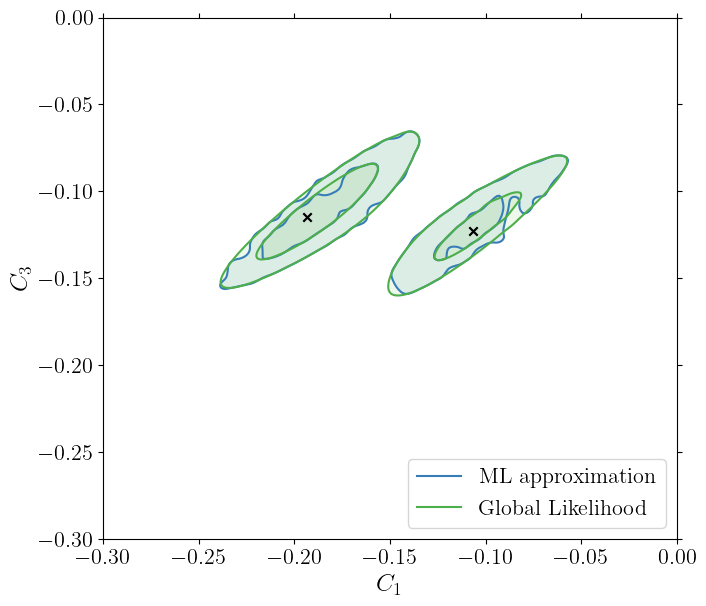

In [55]:
likelihood_plot(read_meshgrid2('C1', 'C3'),
                -0.3, 0.0, -0.3, 0.0, [r'$C_1$', r'$C_3$'], locleg='lower right',
                colors=[1,2], bf=([bf3[0], bf3[1]], [bf3_2[0], bf3_2[1]]),
                widths=[1.5,]*5, ticks=(0.05, 0.05),  fout='../data/plots/scIII_MLlh_C1C3')

linewidths is ignored by contourf


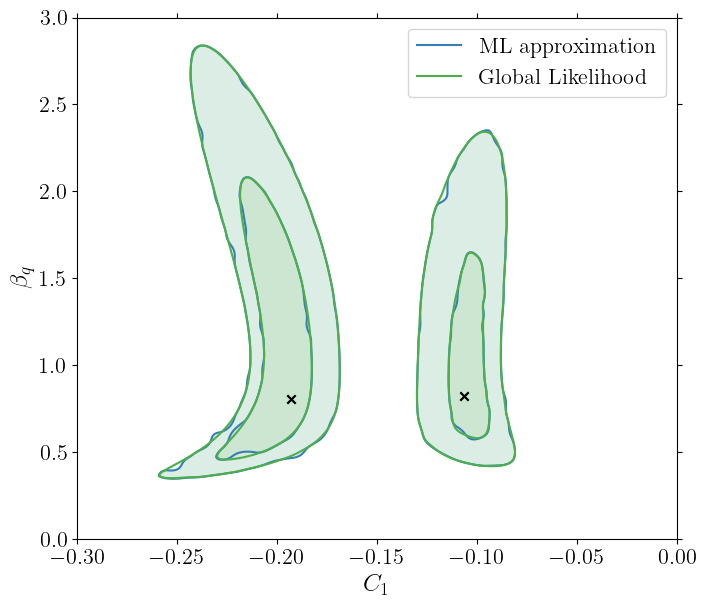

In [56]:
likelihood_plot(read_meshgrid2('C1', 'bq'),
                -0.3, 0.0, 0.0, 3.0, [r'$C_1$', r'$\beta_q$'], locleg='upper right',
                colors=[1,2], bf=([bf3[0], bf3[2]], [bf3_2[0], bf3_2[2]]),
                widths=[1.5,]*5, ticks=(0.05, 0.5),  fout='../data/plots/scIII_MLlh_C1bq')

linewidths is ignored by contourf


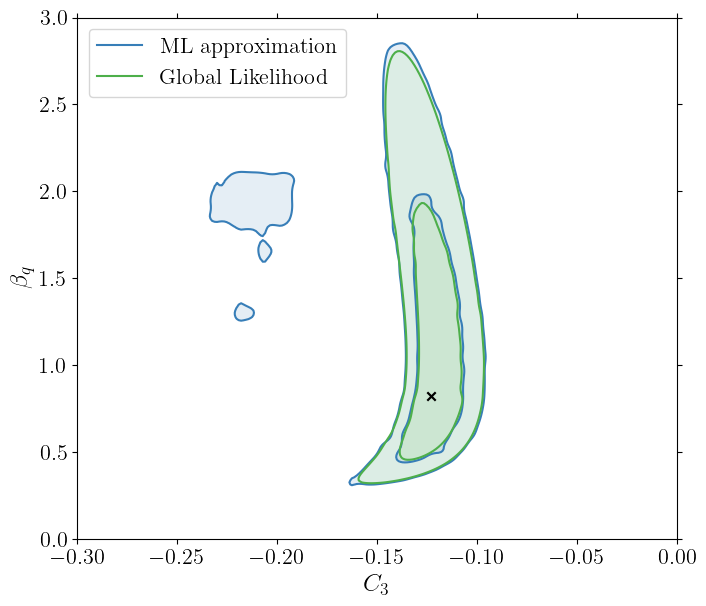

In [58]:
likelihood_plot(read_meshgrid2('C3', 'bq'),
                -0.3, 0.0, 0.0, 3.0, [r'$C_3$', r'$\beta_q$'], locleg='upper left',
                colors=[1,2], bf=([bf3[1], bf3[2]]),
                widths=[1.5,]*5, ticks=(0.05, 0.5),  fout='../data/plots/scIII_MLlh_C3bq')